# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [3]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [5]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [6]:
print df.shape, df.is_blocked.mean()
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [7]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.228222107326
Count: 1204949


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [8]:
np.sum(df['is_blocked'])

274996

In [9]:
dump_df = df.copy()

In [10]:
tmp_df1 = df.copy()[:1200000]
tmp_df2 = df.copy()[:350000]
tmp_true_df = tmp_df1[df['is_blocked']==1]
tmp_fals_df = tmp_df2[df['is_blocked']==0]
#< downsample data so that both classes have approximately equal ratios>

df = pd.concat([tmp_true_df,tmp_fals_df])


print "Blocked ratio:",df.is_blocked.mean()
print "Count:",len(df)

/Users/saxenov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/saxenov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Blocked ratio: 0.50367614606
Count: 543776


In [11]:
ndf = df.iloc[np.random.permutation(len(df))]
ndf.index = list(range(len(ndf)))
df = ndf

In [12]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


In [13]:
#In case your RAM-o-meter is in the red
if very_low_RAM:
    data = data[::2]

# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [14]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

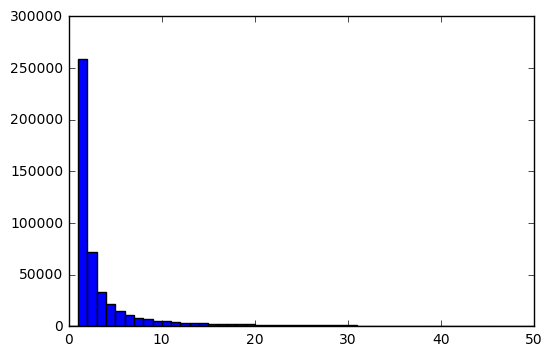

In [15]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [16]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10 #####???
tokens = [x for x in token_counts.keys() if token_counts[x] >= min_count]


In [17]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [18]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 87360


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [19]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [20]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [21]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (543776, 15)
Натуральное шерстяное пальто берет В подарок -> [78087 60198 12183 75088 79843 10083     0     0     0     0] ...
Пневматический револьвер -> [27816  1593     0     0     0     0     0     0     0     0] ...
Сдам коммерческую недвижимость, ул. Косарева 33 -> [77733 52755 16380 26104     0 62356     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [22]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [23]:
df

,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,21438087,Личные вещи,"Одежда, обувь, аксессуары",Натуральное шерстяное пальто берет В подарок,"Продам очень красивое, молочного цвета оригина...","{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",2700,NaN,0,0,0,0,0.10
1,36688079,Хобби и отдых,Коллекционирование,Пневматический револьвер,продам пневматический пистолет в отличном сост...,"{""Вид товара"":""Макеты оружия""}",4000,1.0,1,0,0,0,0.07
2,20585797,Недвижимость,Коммерческая недвижимость,"Сдам коммерческую недвижимость, ул. Косарева 33","Сдам коммерческую недвижимость Косарева 33, бы...","{""Тип объявления"":""Аренда"", ""Вид объекта"":""Дру...",1070000,NaN,0,2,0,0,0.07
3,25107432,Личные вещи,"Одежда, обувь, аксессуары",Норковая шапка коричневого цвета,Продаю норковую шапку коричневого цвета.,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",410,NaN,0,0,0,0,12.40
4,15736294,Транспорт,Грузовики и спецтехника,Камаз,продаю камазика термобудка 7 тон 230 л.с камин...,"{""Вид техники"":""Грузовики""}",800000,NaN,0,0,0,0,1.60
5,15896198,Личные вещи,Детская одежда и обувь,Меховое болеро,"Продам новое меховое болеро, на 1-3 года. Идеа...","{""Вид одежды"":""Для девочек"", ""Предмет одежды"":...",600,NaN,0,0,0,0,8.09
6,14359122,Недвижимость,Квартиры,"2-к квартира, 44 м², 4/5 эт.","В хорошем состоянии, мебель есть, холодильник,...","{""Тип объявления"":""Сдам"", ""Количество комнат"":...",15000,NaN,0,0,0,0,23.44
7,35375289,Хобби и отдых,Коллекционирование,Старина в коллекцию. Крестики Лунницы Привески,"Все вещи подлинные ! , цена за одну шт. от 100...","{""Вид товара"":""Другое""}",1000,NaN,0,0,0,0,1.60
8,30875543,Личные вещи,Детская одежда и обувь,Комплект зимний Тикет,Комплект зимний Тикет ^p размер 104 ^p в идеал...,"{""Вид одежды"":""Для девочек"", ""Предмет одежды"":...",3000,NaN,0,0,0,0,23.41
9,56743897,Услуги,Предложения услуг,Услуга Антистресс. Ваш врач-стоматолог,"Услуга Антистресс - ^p комплекс мер, направле...","{""Вид услуги"":""Красота, здоровье""}",0,0.0,1,1,0,0,21.32


In [24]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

cat_set = set(df['category'])
subcat_set = set(df['subcategory'])

#categories = [A list of dictionaries {"category":category_name, "subcategory":subcategory_name} for each data sample]

categories = []

for i,c in enumerate(data_cat_subcat):
    categories.append({'category':c[0],'subcategory':data_cat_subcat[i][1]})


In [25]:
categories[0]

{'category': '\xd0\x9b\xd0\xb8\xd1\x87\xd0\xbd\xd1\x8b\xd0\xb5 \xd0\xb2\xd0\xb5\xd1\x89\xd0\xb8',
 'subcategory': '\xd0\x9e\xd0\xb4\xd0\xb5\xd0\xb6\xd0\xb4\xd0\xb0, \xd0\xbe\xd0\xb1\xd1\x83\xd0\xb2\xd1\x8c, \xd0\xb0\xd0\xba\xd1\x81\xd0\xb5\xd1\x81\xd1\x81\xd1\x83\xd0\xb0\xd1\x80\xd1\x8b'}

In [26]:
vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [27]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [28]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = np.array(df_non_text.astype('float32'))

In [29]:
#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard


th = 45000

title_tr = title_tokens[:th]
title_ts = title_tokens[th:]
desc_tr = desc_tokens[:th]
desc_ts = desc_tokens[th:]
target_tr = target[:th]
target_ts = target[th:]
nontext_tr = df_non_text[:th]
nontext_ts = df_non_text[th:]
#,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = <define_these_variables>

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [663]:
save_prepared_data = True #save
read_prepared_data = False #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"        

Saving preprocessed data (may take up to 3 minutes)


NameError: name 'data_tuple' is not defined

# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [30]:
#libraries
import lasagne
from theano import tensor as T
import theano

In [31]:
help(lasagne)

Help on package lasagne:

NAME
    lasagne - Tools to train neural nets in Theano

FILE
    /Users/saxenov/anaconda/lib/python2.7/site-packages/lasagne/__init__.py

PACKAGE CONTENTS
    conftest
    init
    layers (package)
    nonlinearities
    objectives
    random
    regularization
    theano_extensions (package)
    updates
    utils

DATA
    __version__ = '0.2.dev1'

VERSION
    0.2.dev1




In [32]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [33]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [34]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=64)
descr_nn = lasagne.layers.LSTMLayer(descr_nn,num_units=15)
descr_nn = lasagne.layers.SliceLayer(descr_nn, -1, 1)
#RNN or LSTM over embedding, maybe several ones in a stack

# Titles
#title_nn = title_inp#lasagne.layers.FlattenLayer(title_inp)#<Process titles somehow (title_inp)>

title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=64)
title_nn = lasagne.layers.LSTMLayer(title_nn,num_units=15)
title_nn = lasagne.layers.SliceLayer(title_nn, -1, 1)

# Non-sequences
#cat_nn = lasagne.layers.EmbeddingLayer(cat_inp, input_size=len(token_to_id)+1, output_size=64)
#descr_nn = lasagne.layers.LSTMLayer(cat_nn,num_units=15)
cat_nn = lasagne.layers.DenseLayer(cat_inp, num_units=100)#lasagne.layers.FlattenLayer(title_inp)#<Process non-sequences(cat_inp)>

In [35]:
nn = lasagne.layers.concat([descr_nn,title_nn,cat_nn])
#<merge three layers into one (e.g. lasagne.layers.concat) >                                  

nn = lasagne.layers.DenseLayer(nn,3)
nn = lasagne.layers.DropoutLayer(nn,p=0.4)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [36]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [37]:
from lasagne.objectives import theano

In [38]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y).mean()

In [39]:
#Weight optimization step
updates = lasagne.updates.adagrad(loss, weights)

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [40]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,target_y).mean()

### Coffee-lation

In [41]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [42]:
#average precision at K

from oracle import APatK, score

In [43]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [44]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 50

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        #print j
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        #print loss
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    print(epoch_y_true)
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

Train:
	loss: 252.075360101
	acc: 0.493921568627
	auc: 0.486968887803
	ap@k: 0.328328388179
[0 1 1 ..., 1 0 0]
Val:
	loss: 1.00113734965
	acc: 0.498823529412
	auc: 0.5
	ap@k: 0.382762336442
Train:
	loss: 0.992812521137
	acc: 0.508823529412
	auc: 0.486400993774
	ap@k: 0.441238906183
[1 1 1 ..., 0 0 0]
Val:
	loss: 0.994584287312
	acc: 0.504901960784
	auc: 0.5
	ap@k: 0.503389537363
Train:
	loss: 0.993656343997
	acc: 0.505882352941
	auc: 0.482150547558
	ap@k: 0.441457607713
[1 1 1 ..., 1 0 1]
Val:
	loss: 0.992574816097
	acc: 0.505490196078
	auc: 0.5
	ap@k: 0.459108661421
Train:
	loss: 0.995564827937
	acc: 0.505098039216
	auc: 0.487957225542
	ap@k: 0.468780340642
[1 1 1 ..., 0 1 1]
Val:
	loss: 0.991071796669
	acc: 0.506274509804
	auc: 0.5
	ap@k: 0.591394782323
Train:
	loss: 0.982242710892
	acc: 0.511764705882
	auc: 0.49211405007
	ap@k: 0.459995502464
[0 1 0 ..., 1 1 0]
Val:
	loss: 0.99257422866
	acc: 0.50431372549
	auc: 0.5
	ap@k: 0.547374981272
Train:
	loss: 1.00594229715
	acc: 0.497450980

In [45]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. 


# Final evaluation
Evaluate network over the entire test set

In [49]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.993946913052
	acc: 0.503878083016
	auc: 0.5
	ap@k: 0.504876038774

AUC:
	Может быть, она недоучилась? Ну или слишком маленькая? Или в детстве болела? (not ok)

Accuracy:
Надо бы подтянуть. (not ok)

Average precision at K:
	Надо бы поднажать (not ok)


# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.